Open Play Shots - Expected Score Model (Multiclassification) - Model Evaluation - GBM

In [1]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/")

In [2]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from expected_score_model.config import open_shots_file_path
# from total_points_model.domain.preprocessing.data_preprocessor import DataPreprocessor
# from total_points_model.domain.contracts.mappings import Mappings
from expected_score_model.domain.contracts.modelling_data_contract import ModellingDataContract
from expected_score_model.domain.modelling.supermodel import SuperXGBClassifier
from expected_score_model.domain.modelling.model_evaluation import XGBClassifierEvaluator

pd.options.display.max_rows = 200
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


New Model

In [3]:
new_version = 1
model_name = "expected_score_open"
model_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models"
preproc_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/preprocessors"

Comparison Model

In [4]:
old_version = new_version - 1
compare_train_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/train_predictions_"+model_name+"_v"+str(old_version)+".csv"
compare_test_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/test_predictions_"+model_name+"_v"+str(old_version)+".csv"

Response

In [5]:
RESPONSE = ModellingDataContract.RESPONSE_MULTICLASS

Load Data

In [6]:
df_modelling = pd.read_csv(open_shots_file_path)
df_modelling.tail()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Goal,Behind,Miss,Score,Home_Score,Away_Score,Home_Current_Score,Away_Current_Score,Current_Margin,Event_Type0,Event_Type1,Event_Type2,Event_Type3,x0,x1,x2,x3,y0,y1,y2,y3,Quarter_Duration0,Quarter_Duration1,Quarter_Duration2,Quarter_Duration3,Chain_Duration,Time_Since_Last_Action,Distance_Since_Last_Action,Distance_to_Right_Goal_x,Distance_to_Middle_y,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Angle_to_Middle_Goal_degrees,Visible_Goal_Angle,Visible_Goal_Angle_degrees,Visible_Behind_Angle,Visible_Behind_Angle_degrees,Squared_Distance_to_Middle_Goal,Log_Distance_to_Middle_Goal,Set_Shot,random100,ModellingFilter
9211,211,kickIn,behind,1705.0,4,744,775.0,Sydney,Sydney,Tom Papley,Tom_Papley,Kick,56.0,-36.0,ineffective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,0,1,0,1,0,1,107.0,32.0,75.0,Kick,Gather,Kick,Handball Received,56.0,48.0,7.0,4.0,-36.0,-44.0,-47.0,-37.0,775.0,771.0,769.0,766.0,31.0,4.0,11.313708,24.0,36.0,43.266615,0.982794,56.309932,0.082503,4.727050,0.258900,14.833859,576.0,3.178054,False,16,True
9212,212,kickIn,goal,1740.0,4,787,900.0,Geelong,Geelong,Brandan Parfitt,Brandan_Parfitt,Kick,75.0,0.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,0,6,6,0,113.0,33.0,80.0,Kick,Handball Received,Handball,Loose Ball Get,75.0,75.0,76.0,75.0,0.0,-1.0,-5.0,-6.0,900.0,899.0,898.0,897.0,113.0,1.0,1.000000,5.0,0.0,5.000000,0.000000,0.000000,2.168022,124.218492,-1.429422,-81.899864,25.0,1.609438,False,43,True
9213,218,possGain,goal,1837.0,4,1136,1198.0,Geelong,Geelong,Sam De Koning,Sam_De_Koning,Kick,78.0,1.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,0,6,6,0,119.0,39.0,80.0,Kick,Gather,Kick,Handball Received,78.0,78.0,65.0,64.0,1.0,1.0,-12.0,-9.0,1198.0,1193.0,1190.0,1188.0,62.0,5.0,0.000000,2.0,1.0,2.236068,0.463648,26.565051,-2.442748,-139.959156,-0.440569,-25.242748,4.0,0.693147,False,5,True
9214,227,throwIn,goal,1901.0,4,1452,1458.0,Geelong,Geelong,Joel Selwood,Joel_Selwood,Kick,37.0,17.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,0,6,6,0,125.0,45.0,80.0,Kick,Gather,Knock On,Handball,37.0,37.0,43.0,34.0,17.0,19.0,20.0,25.0,1458.0,1457.0,1455.0,1453.0,6.0,1.0,2.000000,43.0,17.0,46.238512,0.376490,21.571307,0.129338,7.410516,0.403551,23.121747,1849.0,3.761200,False,88,False
9215,233,possGain,goal,1971.0,4,1744,1753.0,Sydney,Sydney,Tom Papley,Tom_Papley,Kick,48.0,-20.0,effective,True,NaN,141,160,Geelong,Sydney,left,2022F4_Geelong_Sydney,2022F4,2022,1,0,0,6,0,6,137.0,45.0,92.0,Kick,Bounce,Handball Received,Handball,48.0,38.0,35.0,37.0,-20.0,-31.0,-33.0,-37.0,1753.0,1752.0,1748.0,1747.0,9.0,1.0,14.866069,32.0,20.0,37.735925,0.558599,32.005383,0.144862,8.299977,0.461317,26.431498,1024.0,3.465736,False,23,True


In [11]:
df_modelling['Kick_Outcome'] = df_modelling['Final_State'].map({'miss':0, 'behind':1, 'goal':2})

In [12]:
training_data = df_modelling[df_modelling[ModellingDataContract.TRAIN_TEST_SPLIT_COL]]
test_data = df_modelling[~df_modelling[ModellingDataContract.TRAIN_TEST_SPLIT_COL]]

In [13]:
X_train, y_train = training_data.drop(columns=[RESPONSE]), training_data[RESPONSE]
X_test, y_test = test_data.drop(columns=[RESPONSE]), test_data[RESPONSE]

In [14]:
X_test.head()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Goal,Behind,Miss,Score,Home_Score,Away_Score,Home_Current_Score,Away_Current_Score,Current_Margin,Event_Type0,Event_Type1,Event_Type2,Event_Type3,x0,x1,x2,x3,y0,y1,y2,y3,Quarter_Duration0,Quarter_Duration1,Quarter_Duration2,Quarter_Duration3,Chain_Duration,Time_Since_Last_Action,Distance_Since_Last_Action,Distance_to_Right_Goal_x,Distance_to_Middle_y,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Angle_to_Middle_Goal_degrees,Visible_Goal_Angle,Visible_Goal_Angle_degrees,Visible_Behind_Angle,Visible_Behind_Angle_degrees,Squared_Distance_to_Middle_Goal,Log_Distance_to_Middle_Goal,Set_Shot,random100,ModellingFilter
2,10,possGain,goal,110.0,1,285,306.0,Brisbane Lions,Brisbane Lions,Joe Daniher,Joe_Daniher,Kick,50.0,24.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,0,6,6,0,12.0,0.0,12.0,Kick,Gather,Kick Inside 50 Result,Kick Into F50,50.0,50.0,50.0,-8.0,24.0,28.0,28.0,44.0,306.0,305.0,304.0,303.0,21.0,1.0,4.000000,28.0,24.0,36.878178,0.708626,40.601295,0.132764,7.606837,0.424028,24.295030,784.0,3.332205,False,83,False
7,50,possGain,behind,512.0,1,1462,1500.0,Brisbane Lions,Brisbane Lions,Oscar McInerney,Oscar_McInerney,Kick,65.0,-15.0,ineffective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,0,1,0,1,1,0,19.0,15.0,4.0,Kick,Hard Ball Get Crumb,Spoil,Kick Inside 50 Result,65.0,62.0,60.0,60.0,-15.0,-16.0,-17.0,-17.0,1500.0,1499.0,1497.0,1496.0,38.0,1.0,3.162278,13.0,15.0,19.849433,0.856706,49.085617,0.216802,12.421849,0.826928,47.379494,169.0,2.564949,False,90,False
8,79,possGain,goal,747.0,2,709,720.0,Sydney,Sydney,Sam Wicks,Sam_Wicks,Kick,41.0,18.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,0,6,0,6,20.0,40.0,-20.0,Kick,Handball Received,Handball,Handball Received,41.0,38.0,37.0,36.0,18.0,16.0,15.0,15.0,720.0,720.0,719.0,718.0,11.0,0.0,3.605551,37.0,18.0,41.146081,0.452778,25.942295,0.140721,8.062731,0.443767,25.425977,1369.0,3.610918,False,83,False
14,114,possGain,behind,1011.0,2,2025,2032.0,Brisbane Lions,Brisbane Lions,Joe Daniher,Joe_Daniher,Kick,54.0,35.0,ineffective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,0,1,0,1,1,0,50.0,52.0,-2.0,Kick,Loose Ball Get,Kick Inside 50 Result,Kick Into F50,54.0,49.0,41.0,-9.0,35.0,33.0,31.0,42.0,2032.0,2029.0,2027.0,2027.0,7.0,3.0,5.385165,24.0,35.0,42.438190,0.969723,55.561011,0.085774,4.914467,0.269657,15.450186,576.0,3.178054,False,87,False
15,123,centreBounce,goal,1086.0,3,128,143.0,Brisbane Lions,Brisbane Lions,Zac Bailey,Zac_Bailey,Kick,32.0,8.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021,1,0,0,6,6,0,51.0,58.0,-7.0,Kick,Handball Received,Handball,Gather,32.0,22.0,26.0,26.0,8.0,18.0,20.0,20.0,143.0,140.0,139.0,139.0,15.0,3.0,14.142136,46.0,8.0,46.690470,0.172191,9.865807,0.135683,7.774075,0.423021,24.237313,2116.0,3.828641,False,92,False


Preprocess Data

In [15]:
# preprocessor = DataPreprocessor()
# preprocessor.fit(X_train)

# X_train_preproc = preprocessor.transform(X_train)
# X_test_preproc = preprocessor.transform(X_test)

In [16]:
X_train_preproc = X_train[ModellingDataContract.modelling_feature_list]
X_test_preproc = X_test[ModellingDataContract.modelling_feature_list]

In [17]:
X_train_preproc.shape, X_test_preproc.shape

((7208, 2), (2008, 2))

In [18]:
X_train_preproc.head()

,Distance_to_Middle_Goal,Angle_to_Middle_Goal
0,56.080300,0.383818
1,47.010637,0.416065
3,46.486557,0.328553
4,39.560081,0.281772
5,59.682493,0.546167


In [19]:
X_test_preproc.head()

,Distance_to_Middle_Goal,Angle_to_Middle_Goal
2,36.878178,0.708626
7,19.849433,0.856706
8,41.146081,0.452778
14,42.438190,0.969723
15,46.690470,0.172191


Load Model

In [20]:
xgb_model = joblib.load(model_file_path + "/" + model_name + "_v" + str(new_version) + ".joblib")

Get Predictions

In [21]:
train_preds = xgb_model.predict(X_train_preproc)
test_preds = xgb_model.predict(X_test_preproc)

In [22]:
train_miss_probas = xgb_model.predict_proba(X_train_preproc)[:, 0]
train_behind_probas = xgb_model.predict_proba(X_train_preproc)[:, 1]
train_goal_probas = xgb_model.predict_proba(X_train_preproc)[:, 2]

test_miss_probas = xgb_model.predict_proba(X_test_preproc)[:, 0]
test_behind_probas = xgb_model.predict_proba(X_test_preproc)[:, 1]
test_goal_probas = xgb_model.predict_proba(X_test_preproc)[:, 2]

Compare Model

In [23]:
# compare_train_data = pd.read_csv(compare_train_predictions_file_path)
# compare_test_data = pd.read_csv(compare_test_predictions_file_path)

In [24]:
# compare_train_data = compare_train_data.rename(columns = {'xgb_preds':'old_preds',
#                                                           'xgb_probas':'old_probas'})
# compare_test_data = compare_test_data.rename(columns = {'xgb_preds':'old_preds',
#                                                         'xgb_probas':'old_probas'})


In [25]:
# training_data = pd.merge(training_data, compare_train_data, how = "left", on = ["Match_ID", "Chain_Number"])
# test_data = pd.merge(test_data, compare_test_data, how = "left", on = ["Match_ID", "Chain_Number"])

In [26]:
# training_data.tail()

Evaluate Model

In [36]:
training_data['xgb_preds'] = train_preds
training_data['xgb_probas'] = train_goal_probas

train_xgb_evals = XGBClassifierEvaluator(model = xgb_model,
                                       data = training_data,
                                       actual_name = ModellingDataContract.RESPONSE_GOAL,
                                       expected_name = "xgb_probas",
                                       expected_label_name = "xgb_preds",
                                       # compare_name='old_probas'
                                       # compare_label_name="old_preds"
                                       )

In [37]:
test_data['xgb_preds'] = test_preds
test_data['xgb_probas'] = test_goal_probas

test_xgb_evals = XGBClassifierEvaluator(model = xgb_model,
                                       data = test_data,
                                       actual_name = ModellingDataContract.RESPONSE_GOAL,
                                       expected_name = "xgb_probas",
                                       expected_label_name = "xgb_preds",
                                       # compare_name = "old_preds",
                                       # compare_label_name="old_preds"
                                       )

Model Averages

In [38]:
train_xgb_evals.data[[ModellingDataContract.RESPONSE_GOAL, 'xgb_probas']].describe()

,Goal,xgb_probas
count,7208.000000,7208.000000
mean,0.424251,0.431673
std,0.494263,0.147644
min,0.000000,0.150754
25%,0.000000,0.330006
50%,0.000000,0.392658
75%,1.000000,0.494241
max,1.000000,0.841169


In [39]:
test_xgb_evals.data[[ModellingDataContract.RESPONSE_GOAL, 'xgb_probas']].describe()

,Goal,xgb_probas
count,2008.000000,2008.000000
mean,0.441235,0.432686
std,0.496658,0.146269
min,0.000000,0.156452
25%,0.000000,0.332693
50%,0.000000,0.394329
75%,1.000000,0.490904
max,1.000000,0.841169


Plots

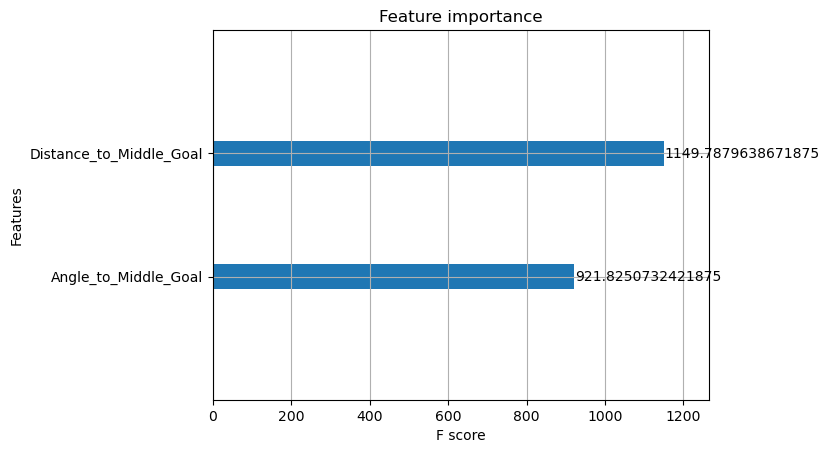

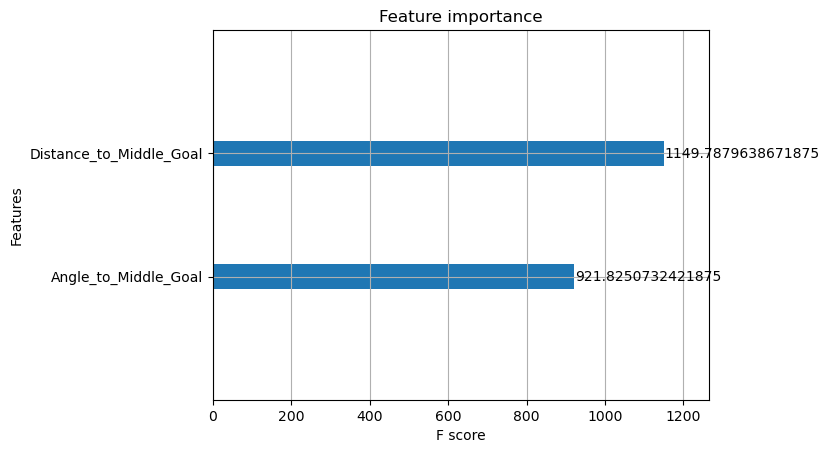

In [40]:
train_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")
test_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

In [61]:
train_xgb_evals.model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.2865929647179113, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.12948586948956814, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.47932972728727347, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=70, missing=nan, monotone_constraints={},
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

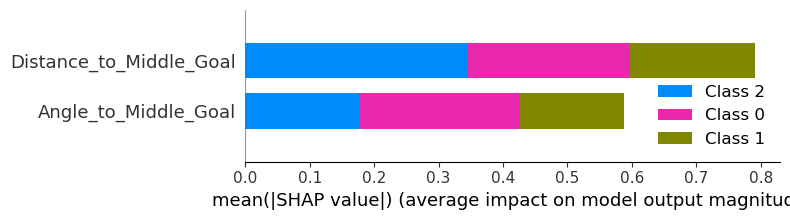

In [66]:
import shap
shap_values = shap.TreeExplainer(train_xgb_evals.model).shap_values(train_xgb_evals.data[ModellingDataContract.modelling_feature_list], check_additivity=False)
shap.summary_plot(shap_values, train_xgb_evals.data[ModellingDataContract.modelling_feature_list])

In [67]:
# train_xgb_evals.plot_shap_summary_plot()
# test_xgb_evals.plot_shap_summary_plot()

In [68]:
# top_features = test_xgb_evals.get_ranked_feature_importance()
# top_10_features = top_features[:10]
# top_10_features

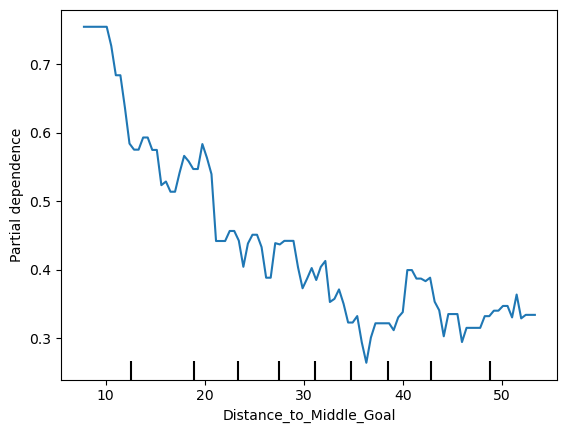

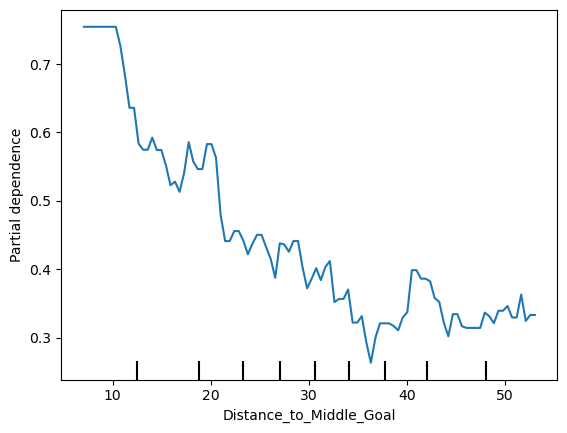

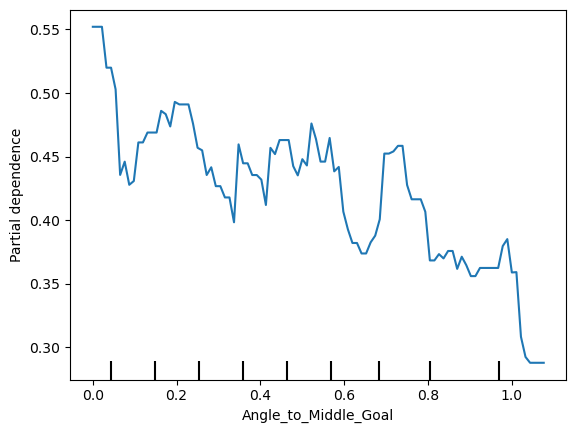

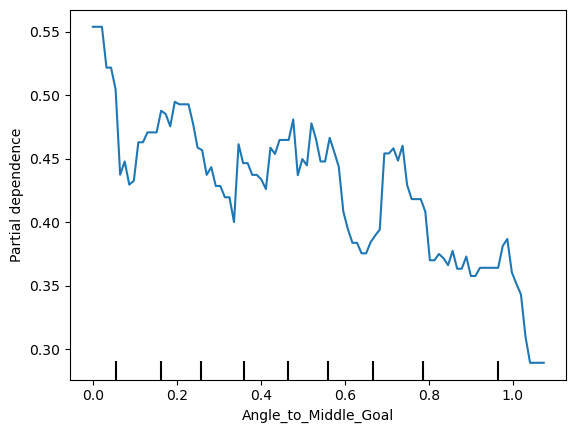

In [71]:
for col in ModellingDataContract.modelling_feature_list:
    train_xgb_evals.plot_pdp([col], target=2)
    test_xgb_evals.plot_pdp([col], target=2)

In [72]:
# for col in ModellingDataContract.modelling_feature_list:
#     train_xgb_evals.plot_ice([col])
#     test_xgb_evals.plot_ice([col])

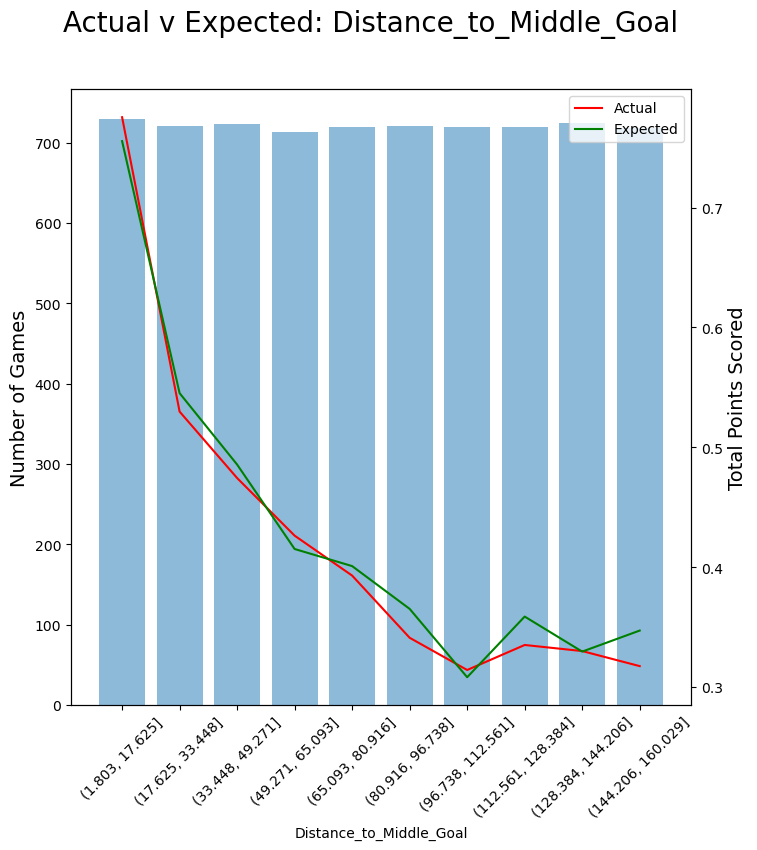

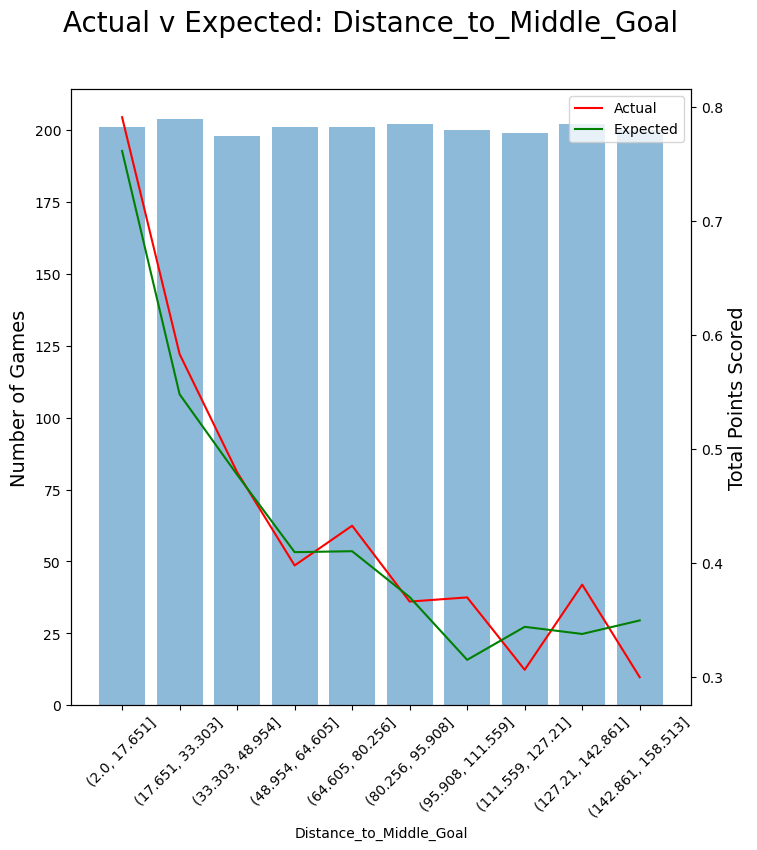

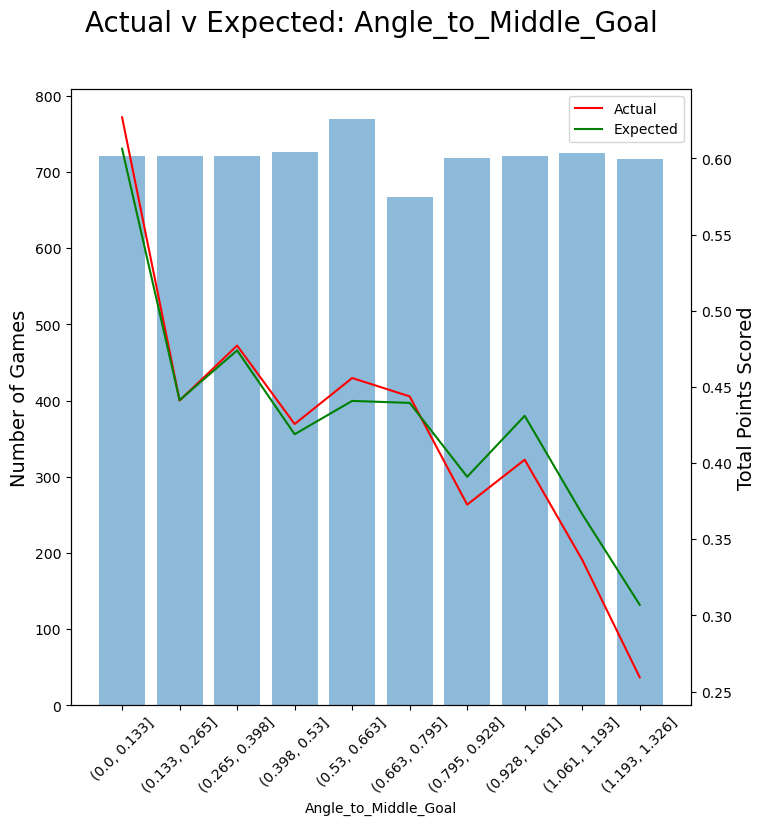

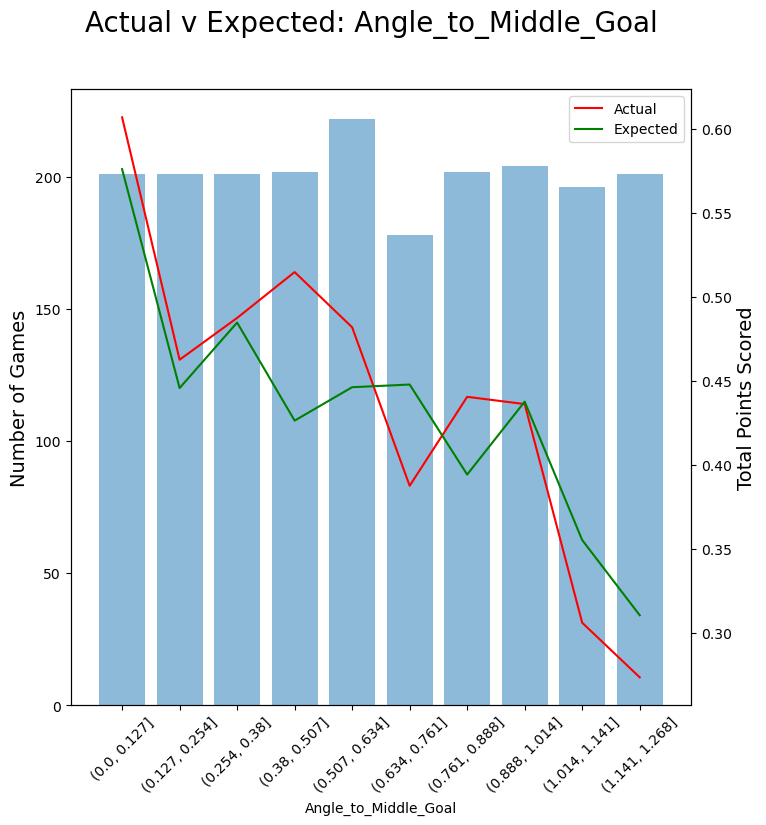

In [70]:
for col in ModellingDataContract.modelling_feature_list:
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [46]:
train_xgb_evals.get_log_loss(), test_xgb_evals.get_log_loss()

Expected Log-Loss: 	0.6237
Expected Log-Loss: 	0.6401


(0.6236612830839547, 0.6400957302209771)

In [47]:
train_xgb_evals.get_brier_score_loss(), test_xgb_evals.get_brier_score_loss()

Expected Brier Score: 	0.2172
Expected Brier Score: 	0.2246


(0.2171746360031622, 0.224551899473557)

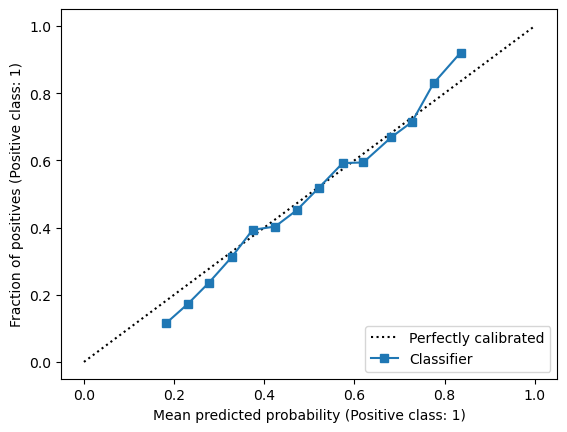

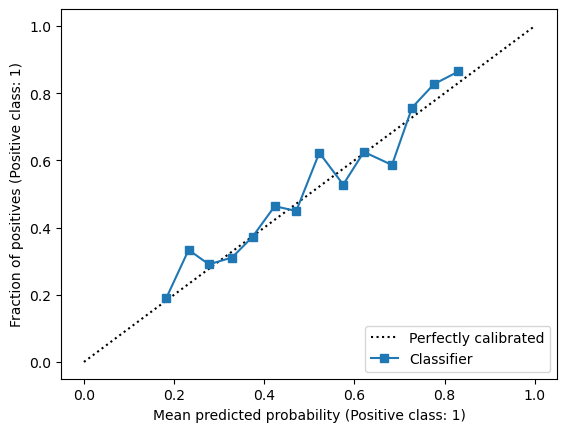

In [48]:
train_xgb_evals.display_calibration_curve(nbins=20)
test_xgb_evals.display_calibration_curve(nbins=20)